# Energy Consumption Analysis for 15-minute Interval Data

This notebook provides a comprehensive analysis of energy consumption data that is recorded at 15-minute intervals. Our goal is to derive meaningful insights from the data and answer specific questions related to energy usage patterns.

**Key Objectives:**
1. Determine annual energy consumption.
2. Calculate the annual cost based on a given electricity price per kWh.
3. Analyze daily consumption patterns and monthly breakdowns.
4. Study consumption differences across days of the week.
5. Examine intra-day consumption distribution.
6. Identify days with peak consumption at 15-minute intervals.
7. Highlight the top 5 days with the highest instantaneous power usage.
8. Create a histogram to visualize quarterly consumption values relative to the total.
9. Compare solar panel production against consumption.
10. Optimize and understand car charger energy consumption.

## Beginning the Analysis

In this analysis, we examine the energy consumption data from multiple meters. The dataset provides consumption values in 15-minute intervals. Our goal is to preprocess this data and derive valuable insights from various perspectives, such as annual, daily, and intra-day consumption patterns.

### Setting up the Environment

To ensure our analysis runs smoothly, we've taken the following steps:

**Created a Virtual Environment:** This helps to keep our project dependencies separate from other Python projects. By using a virtual environment, we ensure that our project runs consistently across different setups.

**Installed Necessary Libraries:** Our project leverages several Python libraries that aid in data manipulation, visualization, and analysis. These libraries have been automatically installed in the virtual environment to guarantee the reproducibility of our analysis.

**Imported Libraries:** The required libraries for this notebook have been imported upfront to streamline the analysis process. These libraries provide a variety of functions and tools essential for our tasks.

**Importing Custom Utility Functions:** To modularize our analysis and promote code reusability, we've defined custom functions in separate Python files. In this section, we'll import these utility functions to be used throughout our notebook.

**Loaded Configuration:** Constants and configurations, such as file paths and threshold values, are sourced from a .env file. This approach promotes better code management and security


### Activating the Virtual Environment

Once you've set up the project with Poetry, you can activate the virtual environment across any operating system using the following command:

```bash
poetry shell
```

This command will start a new shell session with the virtual environment activated. All the dependencies installed via Poetry will be available in this shell session.

Then you have to install Jupyter Kernel for the virtual environment:

```bash
python -m ipykernel install --user --name=zengrid-analysis-poetry
```

### Creating the .env file

In [1]:
# ---------------
# SETTING UP .ENV FILE
# ---------------
# This cell is used to set up the .env file for the consumption analysis.

# Import the function to create the .env file
import os
import sys
sys.path.append('../..')  # This moves one directory up from 'notebooks' to the root.
import src, utils


# Constants for column endings
SOLAR_PANEL_SUFFIX = "/PV"
ELECTRIC_CAR_CHARGER_SUFFIX = "/ECC"
BATTERY_SUFFIX = "/BAT"

# Setting default values for .env file, you can modify here or in the .env file
SOURCE_FILE_PATH = "YOUR_FILE_PATH_HERE"
PRICE_PER_KWH = 0.000
# The threshold for outliers is the number of standard deviations from the mean
THRESHOLD_FOR_OUTLIERS = 1.5

# If you want to force the creation of the .env file, set FORCE_CREATE to True, default is False
FORCE_CREATE = False

# Create the .env file
src.create_dotenv_file_cons_analysis(FORCE_CREATE, SOLAR_PANEL_SUFFIX, ELECTRIC_CAR_CHARGER_SUFFIX, BATTERY_SUFFIX, SOURCE_FILE_PATH, PRICE_PER_KWH, THRESHOLD_FOR_OUTLIERS)


# TODO: Add currency
# TODO: Add RoI, price for solar panels, etc.

### Importing Libraries



In [2]:
# ---------------
# IMPORTING LIBRARIES
# ---------------
# Importing all the necessary libraries required for our analysis.

# Standard Libraries
import os
import calendar
import re

# Third-party Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from dotenv import load_dotenv

# Importing utility functions for data processing and analysis
from utils import data_utils as du

In [3]:
# ---------------
# LOADING CONSTANTS FROM .ENV
# ---------------
# Loading constants and configurations stored in the .env file.
# BEFORE THIS STEP MODIFY THE .env FILE WITH YOUR OWN VALUES

# Load values from .env
load_dotenv()

# Define suffixes
SOLAR_PANEL_SUFFIX = os.getenv('SOLAR_PANEL_SUFFIX', '/PV')  # default value if not found
ELECTRIC_CAR_CHARGER_SUFFIX = os.getenv('ELECTRIC_CAR_CHARGER_SUFFIX', '/ECC')  # default value if not found
BATTERY_SUFFIX = os.getenv('BATTERY_SUFFIX', '/BAT')  # default value if not found

# Define constants
SOURCE_FILE_PATH = os.getenv('SOURCE_FILE_PATH', 'FILE_PATH_HERE')  # default path if not found
PRICE_PER_KWH = float(os.getenv('PRICE_PER_KWH', '183.5'))  # default value if not found
THRESHOLD_FOR_OUTLIERS = float(os.getenv('THRESHOLD_FOR_OUTLIERS', '1.5'))  # default value if not found


### Data Preprocessing

The raw dataset contains date-time information in a non-standard format. In this step:

1. The dataset is loaded into a DataFrame.
2. A new DataFrame is created to hold the processed data.
3. The combined date-time column is split into separate date, start time, and end time values.
4. These separated values are then used to create two new columns: TimePeriodStart and TimePeriodEnd, which represent the start and end of each 15-minute interval in a standard datetime format.
5. The original combined date-time column is dropped.

In [5]:
# Task1: Load and preprocess the data using the defined function
processed_data = du.load_and_preprocess_data(SOURCE_FILE_PATH)

# Extracting date, start time, and end time from 'Időszeletek'
date = processed_data['Időszeletek'].str.split(' ').str[0]
start_time = processed_data['Időszeletek'].str.split(' - ').str[0].str.split(' ').str[1]
end_time = processed_data['Időszeletek'].str.split(' - ').str[1]

processed_data['TimePeriodStart'] = date + ' ' + start_time
processed_data['TimePeriodEnd'] = date + ' ' + end_time

# Adjust for '24:00' in TimePeriodEnd
mask_24 = processed_data['TimePeriodEnd'].str.endswith('24:00')
processed_data.loc[mask_24, 'TimePeriodEnd'] = (pd.to_datetime(processed_data.loc[mask_24, 'TimePeriodEnd'].str.split(' ').str[0]) + pd.Timedelta(days=1)).dt.strftime('%Y.%m.%d') + ' 00:00'

processed_data['TimePeriodStart'] = pd.to_datetime(processed_data['TimePeriodStart'], format='%Y.%m.%d %H:%M')
processed_data['TimePeriodEnd'] = pd.to_datetime(processed_data['TimePeriodEnd'], format='%Y.%m.%d %H:%M')

processed_data.drop('Időszeletek', axis=1, inplace=True)

# Replace NaN values with 0
processed_data.fillna(0, inplace=True)

# Extracting DayOfWeek, Month, Hour, and Minute from 'TimePeriodStart'
processed_data['DayOfWeek'] = processed_data['TimePeriodStart'].dt.dayofweek
processed_data['Month'] = processed_data['TimePeriodStart'].dt.month
processed_data['Hour'] = processed_data['TimePeriodStart'].dt.hour
processed_data['Minute'] = processed_data['TimePeriodStart'].dt.minute

# Task 3: Distinguish between different meters
consumption_meter_columns = [col for col in processed_data.columns if SOLAR_PANEL_SUFFIX not in col and ELECTRIC_CAR_CHARGER_SUFFIX not in col and BATTERY_SUFFIX not in col and 'TimePeriod' not in col and col != 'DayOfWeek' and col != 'Month' and col != 'Hour' and col != 'Minute']
solar_panel_columns = [col for col in processed_data.columns if SOLAR_PANEL_SUFFIX in col]
electric_car_charger_columns = [col for col in processed_data.columns if ELECTRIC_CAR_CHARGER_SUFFIX in col]
battery_columns = [col for col in processed_data.columns if BATTERY_SUFFIX in col]

# Creating "Pods" dictionary, "Pods" are the pair of Consumption Meters and Solar Panels, not every Consumption Meter has a Solar Panel
pods = {}

for meter in consumption_meter_columns:
    solar_panel = meter + SOLAR_PANEL_SUFFIX
    if solar_panel in solar_panel_columns:
        pods[meter] = (meter, solar_panel)
    else:
        pods[meter] = (meter, None)


# Display the processed data and its types
processed_data.head(), processed_data.dtypes

                 Időszeletek  HU000210F11-S00000000000005002213
0   2023.08.02 00:00 - 00:15                               2.85
1   2023.08.02 00:15 - 00:30                               2.85
2   2023.08.02 00:30 - 00:45                               2.70
3   2023.08.02 00:45 - 01:00                               2.55
4   2023.08.02 01:00 - 01:15                               2.25
5   2023.08.02 01:15 - 01:30                               2.10
6   2023.08.02 01:30 - 01:45                               2.10
7   2023.08.02 01:45 - 02:00                               2.40
8   2023.08.02 02:00 - 02:15                               2.25
9   2023.08.02 02:15 - 02:30                               2.10
10  2023.08.02 02:30 - 02:45                               2.10
11  2023.08.02 02:45 - 03:00                               2.10
12  2023.08.02 03:00 - 03:15                               2.10
13  2023.08.02 03:15 - 03:30                               2.10
14  2023.08.02 03:30 - 03:45            

d:\Repos\zengrid-analysis\notebooks\cons-analysis\../..\utils\data_utils.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row[datum_col_idx].split("T")[0]
d:\Repos\zengrid-analysis\notebooks\cons-analysis\../..\utils\data_utils.py:142: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  {"Datum": f"{date_str} {interval}", row[mp_col_idx]: row[a_col_idx]}


(   HU000210F11-S00000000000005002213     TimePeriodStart       TimePeriodEnd  \
 0                               2.85 2023-08-02 00:00:00 2023-08-02 00:15:00   
 1                               2.85 2023-08-02 00:15:00 2023-08-02 00:30:00   
 2                               2.70 2023-08-02 00:30:00 2023-08-02 00:45:00   
 3                               2.55 2023-08-02 00:45:00 2023-08-02 01:00:00   
 4                               2.25 2023-08-02 01:00:00 2023-08-02 01:15:00   
 
    DayOfWeek  Month  Hour  Minute  
 0          2      8     0       0  
 1          2      8     0      15  
 2          2      8     0      30  
 3          2      8     0      45  
 4          2      8     1       0  ,
 HU000210F11-S00000000000005002213           float64
 TimePeriodStart                      datetime64[ns]
 TimePeriodEnd                        datetime64[ns]
 DayOfWeek                                     int32
 Month                                         int32
 Hour                   

In [6]:
# Testing the pods
for meter, solar_panel in pods.items():
    if solar_panel:
        print(f"Pod: {meter} with Solar Panel: {solar_panel}")
    else:
        print(f"Pod: {meter} without Solar Panel")


Pod: HU000210F11-S00000000000005002213 with Solar Panel: ('HU000210F11-S00000000000005002213', None)


### Task 1: Calculate annual consumption
This task involves understanding the annual consumption of each meter and calculating associated costs:

1. The annual consumption for each meter is computed by summing up its respective values.
2. The annual cost for each meter is derived using a given price per kWh.
3. Average daily consumption is computed for each 15-minute interval throughout the entire year.
4. Average monthly consumption is calculated for each 15-minute interval, grouped by month.
5. A visualization is created to showcase the average consumption per hour throughout the year.

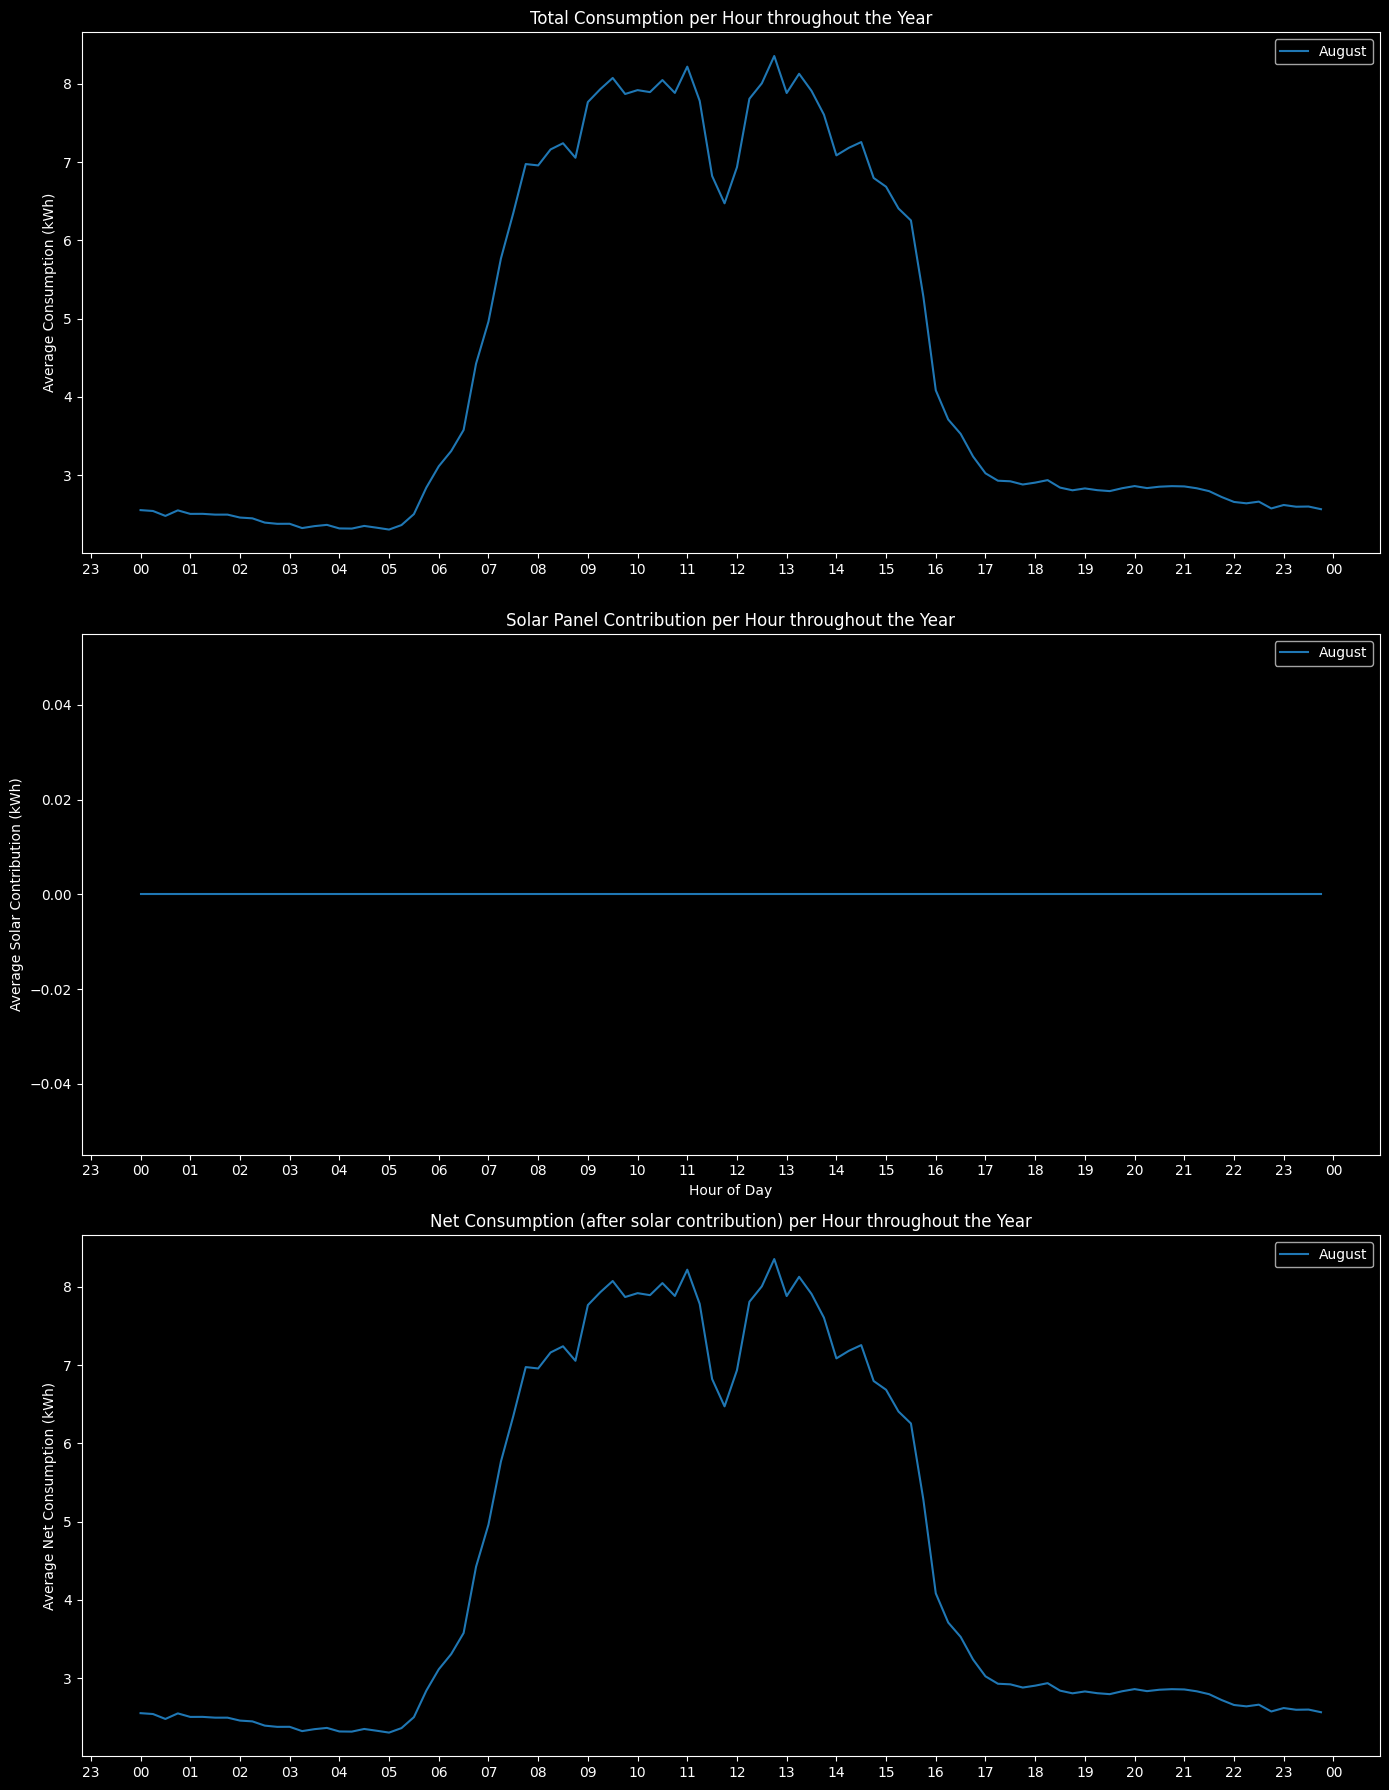

In [7]:
# Step 1: Calculate annual consumption for each type of meter
annual_consumption = processed_data[consumption_meter_columns].sum()

# Step 2: Calculate annual costs
annual_costs = annual_consumption * PRICE_PER_KWH

# Step 3: Average daily consumption for each 15-minute interval is already done in preprocessing
# We have 'Hour' and 'Minute' columns created in the preprocessing step.
avg_daily_consumption = processed_data.groupby(['Hour', 'Minute']).mean().reset_index()

# Step 4: Average daily consumption for each 15-minute interval grouped by month
# 'Month' column was also created during preprocessing.
avg_monthly_consumption = processed_data.groupby(['Month', 'Hour', 'Minute']).mean().reset_index()

# Generating time column for plotting
avg_monthly_consumption['Time'] = avg_monthly_consumption['Hour'].astype(str).str.zfill(2) + ':' + avg_monthly_consumption['Minute'].astype(str).str.zfill(2)
avg_monthly_consumption['PlotTime'] = pd.to_datetime('2000-01-01 ' + avg_monthly_consumption['Time'])

# Calculate total consumption across all consumption meters and electric car chargers
avg_monthly_consumption['TotalConsumption'] = avg_monthly_consumption[consumption_meter_columns + electric_car_charger_columns].sum(axis=1)

# Calculate the difference contributed by the solar panels
avg_monthly_consumption['SolarContribution'] = avg_monthly_consumption[solar_panel_columns].sum(axis=1)

# Calculate net consumption (total consumption minus solar panel production)
avg_monthly_consumption['NetConsumption'] = avg_monthly_consumption['TotalConsumption'] - avg_monthly_consumption['SolarContribution']

# Define the color palette
palette = sns.color_palette("tab20", 12)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 18))

# Plotting Total Consumption
for month, color in zip(avg_monthly_consumption['Month'].unique(), palette):
    monthly_data = avg_monthly_consumption[avg_monthly_consumption['Month'] == month]
    ax1.plot(monthly_data['PlotTime'], monthly_data['TotalConsumption'], label=calendar.month_name[month], color=color)
ax1.set_title("Total Consumption per Hour throughout the Year")
ax1.set_ylabel("Average Consumption (kWh)")
ax1.legend()

# Plotting Solar Panel Contribution
for month, color in zip(avg_monthly_consumption['Month'].unique(), palette):
    monthly_data = avg_monthly_consumption[avg_monthly_consumption['Month'] == month]
    ax2.plot(monthly_data['PlotTime'], monthly_data['SolarContribution'], label=calendar.month_name[month], color=color)
ax2.set_title("Solar Panel Contribution per Hour throughout the Year")
ax2.set_xlabel("Hour of Day")
ax2.set_ylabel("Average Solar Contribution (kWh)")
ax2.legend()

# Plotting Net Consumption
for month, color in zip(avg_monthly_consumption['Month'].unique(), palette):
    monthly_data = avg_monthly_consumption[avg_monthly_consumption['Month'] == month]
    ax3.plot(monthly_data['PlotTime'], monthly_data['NetConsumption'], label=calendar.month_name[month], color=color)
ax3.set_title("Net Consumption (after solar contribution) per Hour throughout the Year")
ax3.set_ylabel("Average Net Consumption (kWh)")
ax3.legend()

# Formatting axes
for ax in [ax1, ax2, ax3]:
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

plt.tight_layout()
plt.show()

### Task 2: Daily Consumption Patterns and Monthly Breakdowns

This task aims to identify patterns in consumption across different days of the week:

1. Average consumption values for each day of the week are computed.
2. A bar chart is created to showcase the average consumption for each day, from Monday to Sunday.

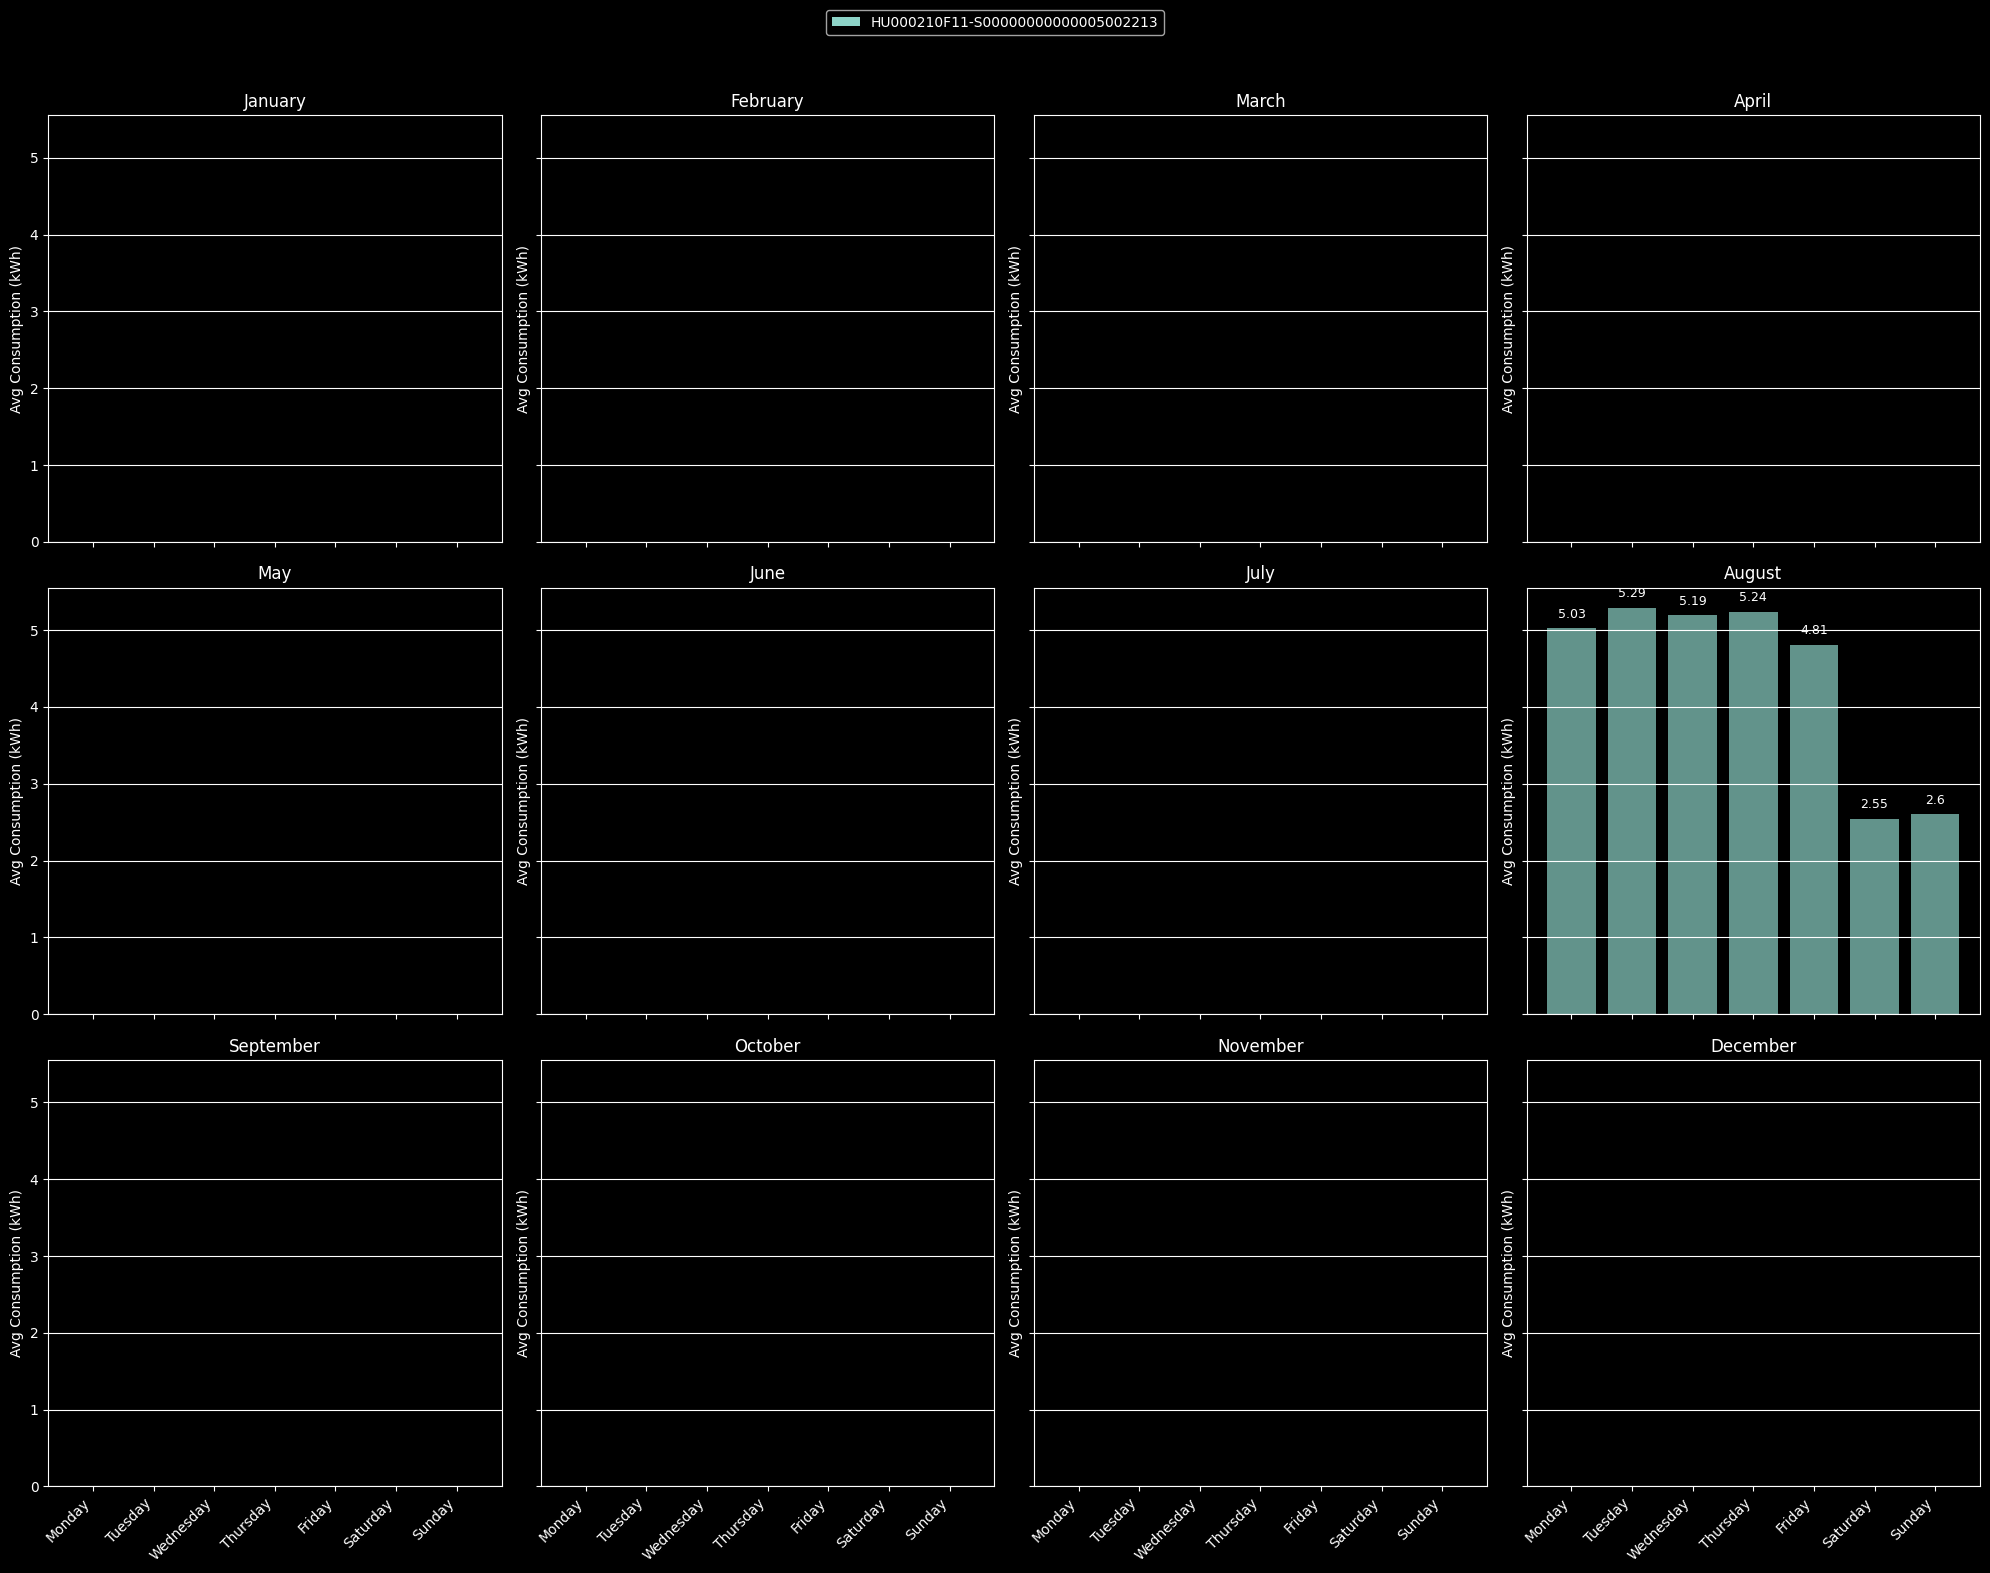

In [8]:
# Include car chargers in the consumption columns
electric_car_charger_columns = [col for col in processed_data.columns if 'ECC' in col]
all_consumption_columns = consumption_meter_columns + electric_car_charger_columns

# Calculate average consumption for the days of the week for each month
processed_data['DayOfWeek'] = processed_data['TimePeriodStart'].dt.dayofweek
avg_weekly_monthly_consumption = processed_data.groupby(['Month', 'DayOfWeek']).mean()[all_consumption_columns].reset_index()

# Convert numerical day representation to actual day names
avg_weekly_monthly_consumption['DayOfWeekName'] = avg_weekly_monthly_consumption['DayOfWeek'].apply(lambda x: calendar.day_name[x])

# Visualization with Enhancements
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15), sharex=True, sharey=True)
days_order = list(calendar.day_name)

for month in range(1, 13):
    ax = axes[(month-1) // 4][(month-1) % 4]
    
    monthly_data = avg_weekly_monthly_consumption[avg_weekly_monthly_consumption['Month'] == month]
    
    bars = []
    for column in all_consumption_columns:
        bars.append(ax.bar(monthly_data['DayOfWeekName'], monthly_data[column], label=column, alpha=0.7))
    
    # Set bar labels
    for bar_set in bars:
        for bar in bar_set:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval,2), ha='center', va='bottom', fontsize=9)
    
    ax.set_title(calendar.month_name[month])
    ax.set_xticks(list(range(7)))  # Set x-ticks for every day
    ax.set_xticklabels(days_order, rotation=45, ha='right')  
    ax.grid(axis='y')
    ax.set_ylabel('Avg Consumption (kWh)')

# Add a legend to the figure
fig.legend(all_consumption_columns, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(all_consumption_columns))

plt.tight_layout()
plt.show()

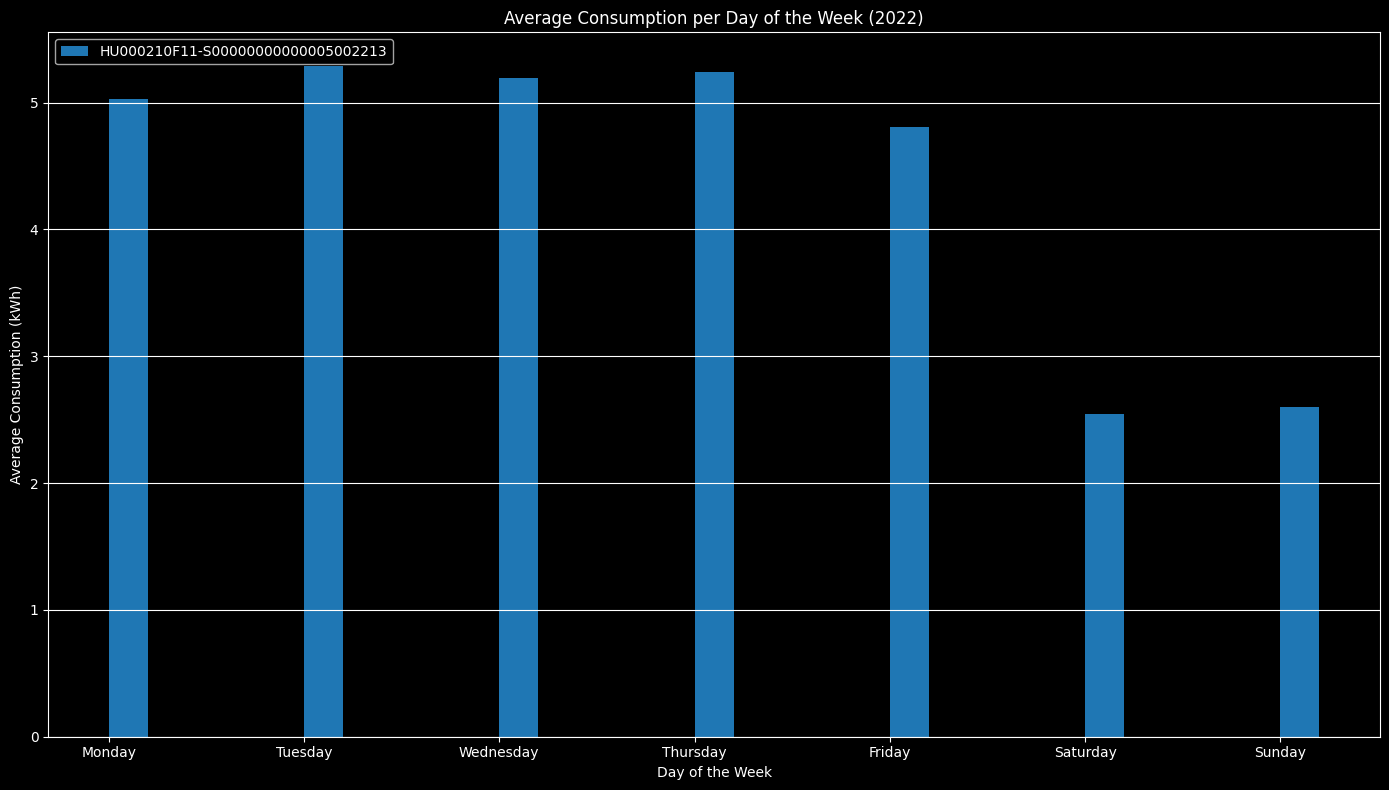

In [9]:
# Extract day of the week
processed_data['DayOfWeek'] = processed_data['TimePeriodStart'].dt.dayofweek

# Calculate average consumption for the days of the week
avg_weekly_consumption = processed_data.groupby('DayOfWeek').mean().reset_index()

# Convert numerical day representation to actual day names
avg_weekly_consumption['DayOfWeek'] = avg_weekly_consumption['DayOfWeek'].apply(lambda x: calendar.day_name[x])

# Visualization of average consumption across the days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_weekday_consumption = avg_weekly_consumption.set_index('DayOfWeek').reindex(days_order).reset_index()

# Set up plotting parameters
width = 0.2
x = np.arange(len(days_order))

plt.figure(figsize=(14, 8))
bar_colors = sns.color_palette("tab10", len(all_consumption_columns))
for idx, (column, color) in enumerate(zip(all_consumption_columns, bar_colors), 1):
    plt.bar(x - width * len(all_consumption_columns) / 2 + idx * width, avg_weekday_consumption[column], width, label=column, color=color)

# Set labels, title, and custom x-axis tick labels
plt.ylabel('Average Consumption (kWh)')
plt.xlabel('Day of the Week')
plt.title('Average Consumption per Day of the Week (2022)')
plt.xticks(x, days_order)
plt.legend(loc='upper left')

plt.tight_layout()
plt.grid(axis='y')
plt.show()

### Task 3: Examining Intra-day Consumption Distribution

This task delves into the consumption patterns within a day:

1. The data is grouped by hours and minutes to determine the average consumption for each 15-minute interval throughout the day.
2. A line plot is created to show the intra-day distribution of average consumption.

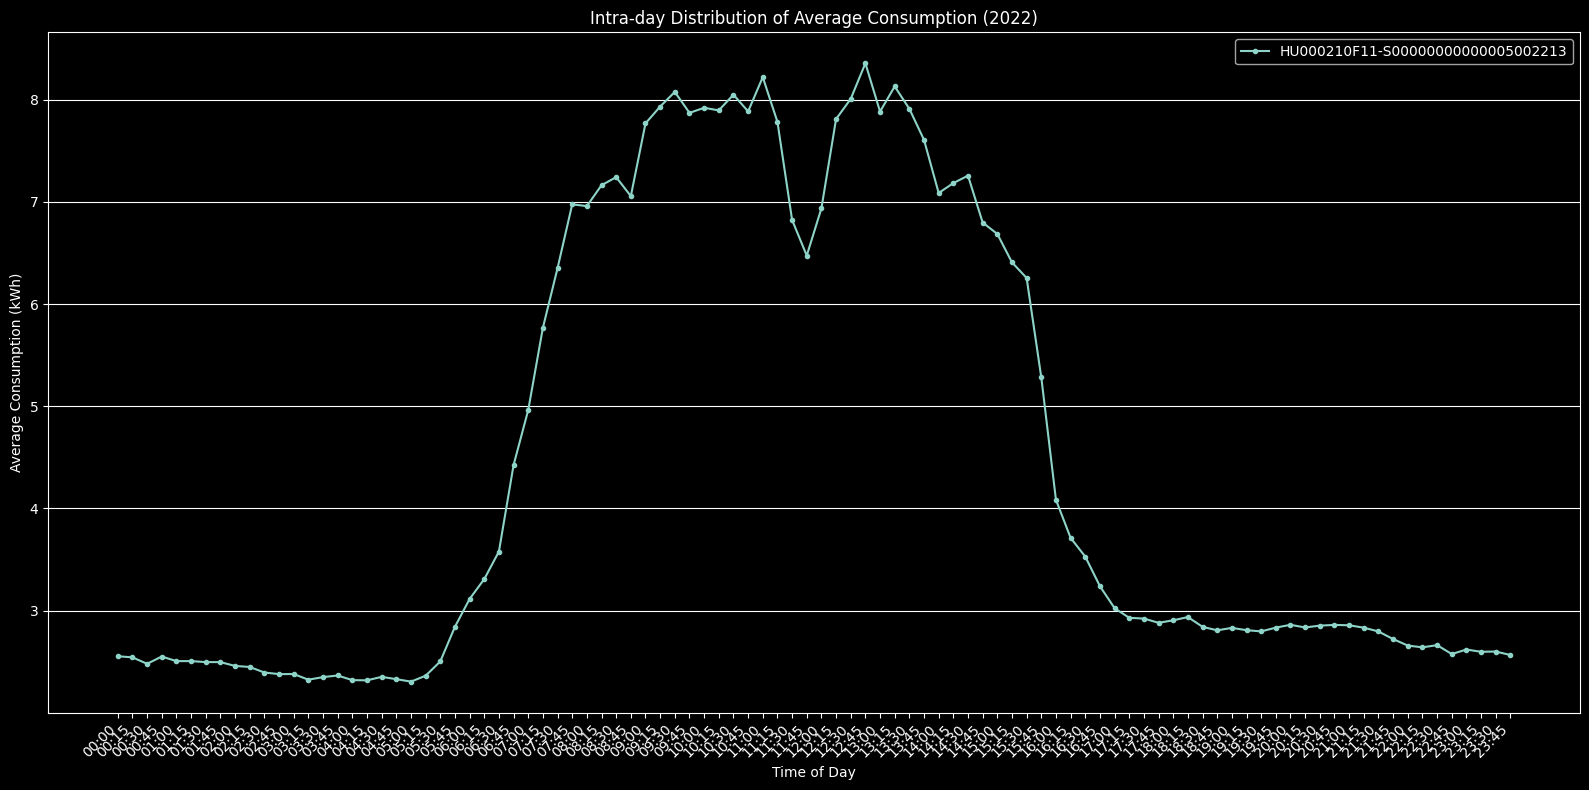

In [10]:
# Step 1: Calculate average consumption for each 15-minute interval of the day

# As we have already extracted 'Hour' and 'Minute' in the preprocessing step, we can directly compute the average.
avg_intra_day = processed_data.groupby(['Hour', 'Minute']).mean()[all_consumption_columns].reset_index()

# Convert 'Hour' and 'Minute' to a time format for better visualization
avg_intra_day['Time'] = avg_intra_day['Hour'].astype(str).str.zfill(2) + ':' + avg_intra_day['Minute'].astype(str).str.zfill(2)

# Step 2: Visualization of intra-day consumption patterns

plt.figure(figsize=(16, 8))

# Plot data for each consumption column
for column in all_consumption_columns:
    plt.plot(avg_intra_day['Time'], avg_intra_day[column], label=column, marker='o', markersize=3)

# Set labels, title, and format the x-axis
plt.xlabel('Time of Day')
plt.ylabel('Average Consumption (kWh)')
plt.title('Intra-day Distribution of Average Consumption (2022)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y')

plt.tight_layout()
plt.show()

### Task 4: Identifying Days with Peak Consumption at 15-minute Intervals

This task focuses on identifying periods of peak consumption:

1. The data is analyzed to find the 15-minute intervals with the highest total power consumption.
2. The top 5 unique days with the highest instantaneous power are identified.
3. A line plot is created to show the intra-day power distribution for these top 5 unique days.

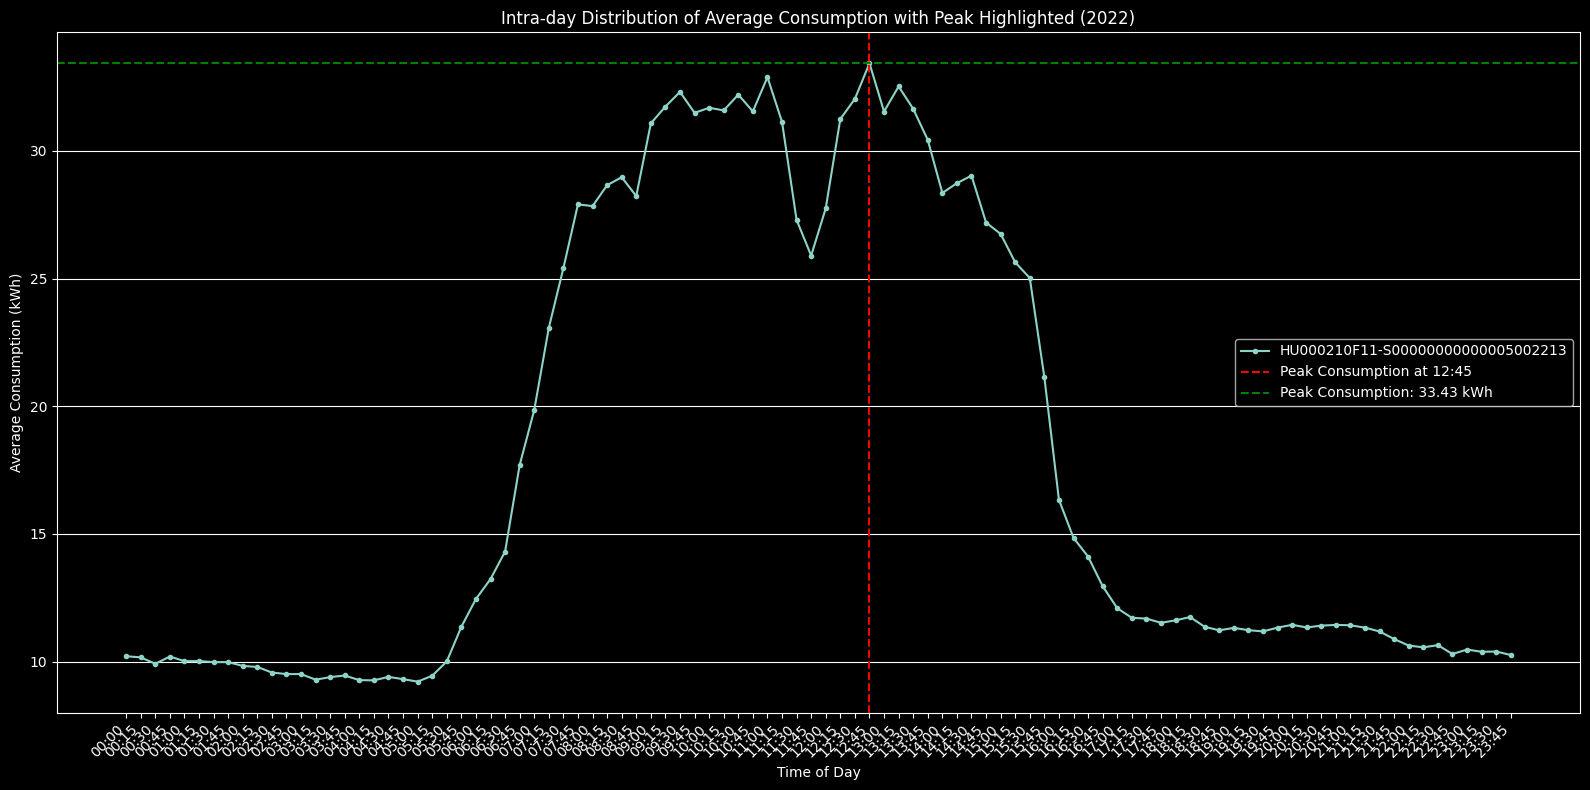

In [11]:
# Step 1: Convert to kWh
# Multiplying by 4 to convert kW readings of 15-minute intervals to kWh
avg_intra_day[all_consumption_columns] *= 4

# Step 2: Calculate total consumption for each time interval
avg_intra_day['Total'] = avg_intra_day[all_consumption_columns].sum(axis=1)

# Step 3: Identify peak consumption time
peak_time = avg_intra_day.iloc[avg_intra_day['Total'].idxmax()]['Time']
peak_value = avg_intra_day['Total'].max()

# Step 4: Visualization

plt.figure(figsize=(16, 8))

# Plot data for each consumption column
for column in all_consumption_columns:
    plt.plot(avg_intra_day['Time'], avg_intra_day[column], label=column, marker='o', markersize=3)

# Highlight the peak consumption period
plt.axvline(peak_time, color='red', linestyle='--', label=f'Peak Consumption at {peak_time}')
plt.axhline(peak_value, color='green', linestyle='--', label=f'Peak Consumption: {peak_value:.2f} kWh')

# Set labels, title, and format the x-axis
plt.xlabel('Time of Day')
plt.ylabel('Average Consumption (kWh)')
plt.title('Intra-day Distribution of Average Consumption with Peak Highlighted (2022)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y')

plt.tight_layout()
plt.show()

### Task 5: Identify the top 5 days with the highest instantaneous power.

The focus of this task is to pinpoint periods of peak consumption:

1. **Highlighting Peak Intervals**:
    - The dataset is first scoured to identify the 15-minute intervals with the top 5 highest total power consumptions. It's worth noting that multiple peak values might occur on the same day. The visual representation of this data will underscore these peak values, allowing us to identify the most power-intensive moments throughout the year.
2. **Analysis of Unique Peak Days**:
    - To get a broader view, we delve deeper to identify the top 5 unique days that experienced the highest instantaneous power. This approach ensures we're not just looking at isolated peak intervals but rather entire days of significant power usage.
    - A line plot is then crafted to vividly display the intra-day power distribution for each of these standout days, painting a clear picture of consumption dynamics on these particularly demanding days.

By the culmination of this task, we'll have a nuanced understanding of both instantaneous power spikes and broader days of high consumption, offering a multifaceted view of peak usage periods.

Top 5 Dates with the Highest Instantaneous Power:
2023-08-22
2023-08-15
2023-08-24
2023-08-03


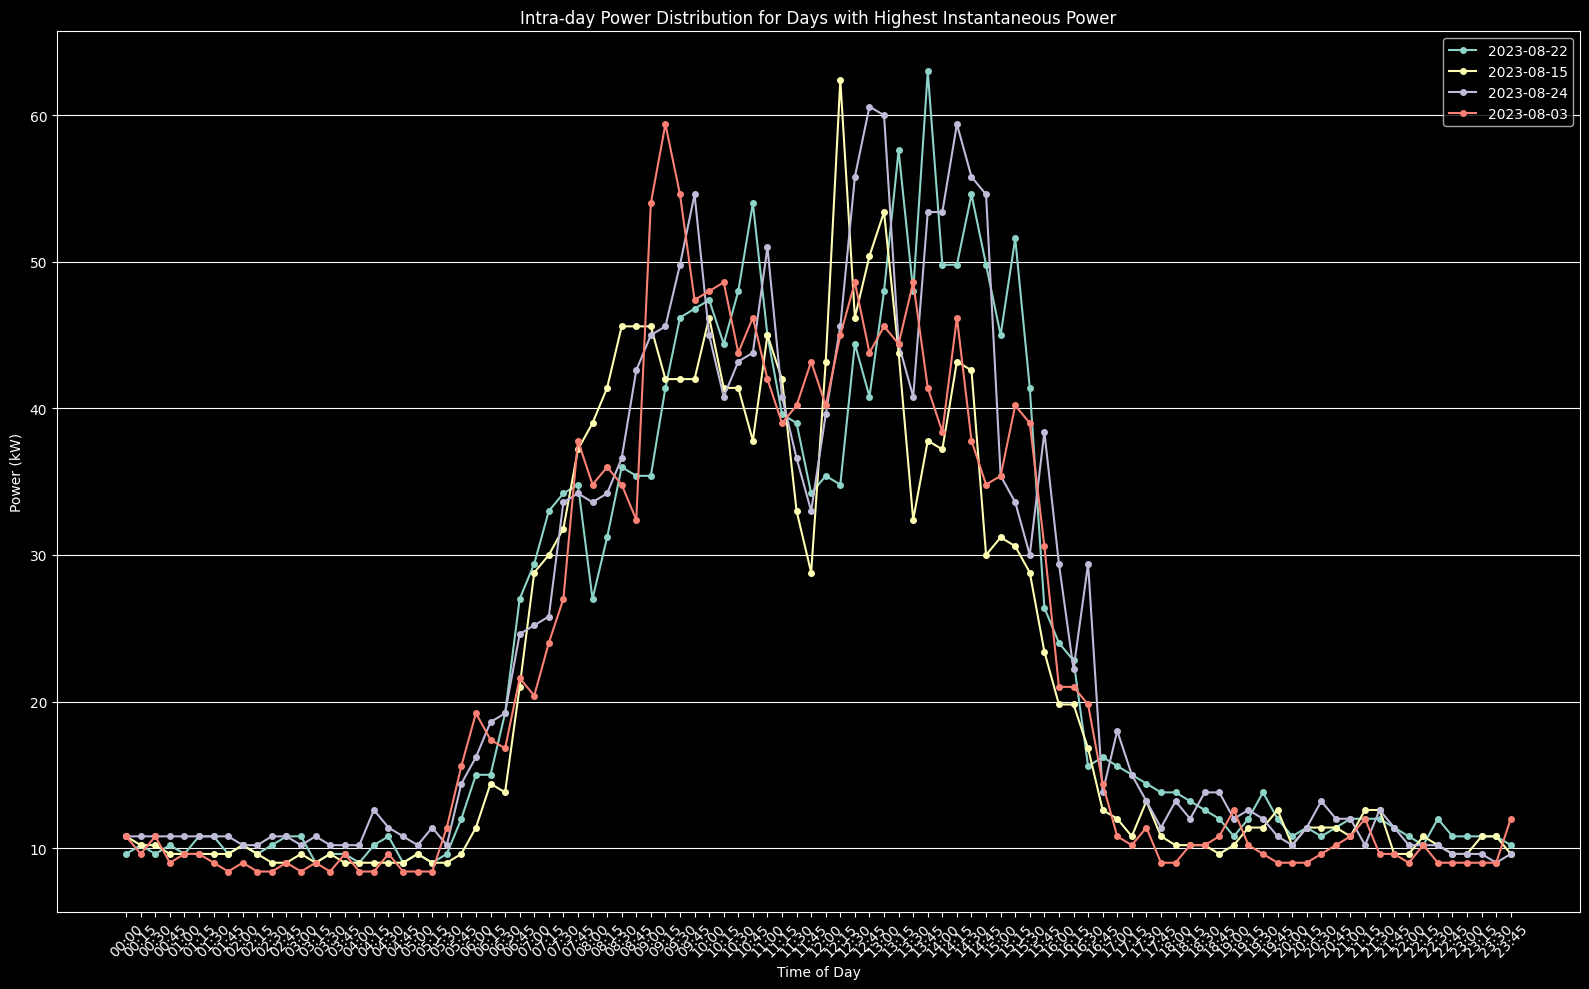

In [12]:
# Step 1: Convert consumption to power (kW)
# Since the data is for 15-minute intervals, we multiply by 4 to get kW
processed_data[all_consumption_columns] *= 4

# Calculate total power for each interval
processed_data['TotalPower'] = processed_data[all_consumption_columns].sum(axis=1)

# Step 2: Identify top 5 intervals with the highest power
top_5_intervals = processed_data.nlargest(5, 'TotalPower')

# Step 3: Extract unique dates from top intervals
unique_top_dates = top_5_intervals['TimePeriodStart'].dt.date.unique()

print("Top 5 Dates with the Highest Instantaneous Power:")
for date in unique_top_dates:
    print(date)

# Step 4: Visualization

plt.figure(figsize=(16, 10))

# Plotting intra-day distribution for each unique top date
for date in unique_top_dates:
    subset = processed_data[processed_data['TimePeriodStart'].dt.date == date]
    time = subset['TimePeriodStart'].dt.strftime('%H:%M')
    plt.plot(time, subset['TotalPower'], label=str(date), marker='o', markersize=4)

# Adjusting the plot
plt.xlabel('Time of Day')
plt.ylabel('Power (kW)')
plt.title('Intra-day Power Distribution for Days with Highest Instantaneous Power')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()

plt.show()

Top 5 Dates with the Highest Instantaneous Power:
2023-08-24
2023-08-22
2023-08-28
2023-08-23
2023-08-03


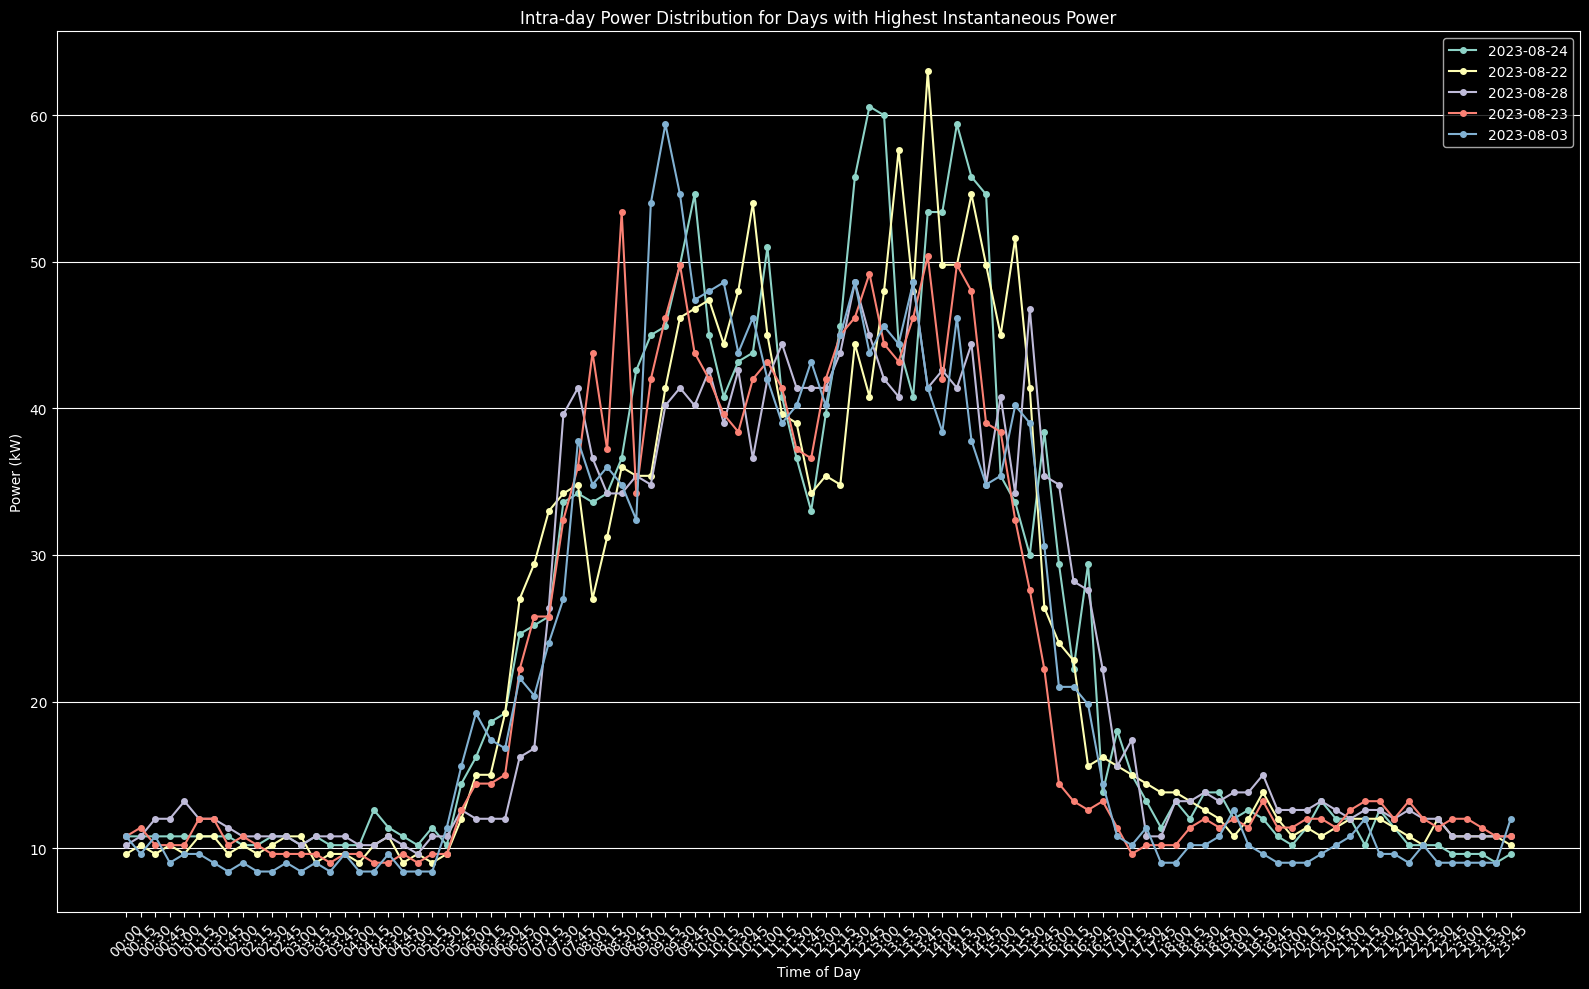

In [13]:
# Calculate daily total power
daily_total_power = processed_data.groupby(processed_data['TimePeriodStart'].dt.date)['TotalPower'].sum()

# Get top 5 unique dates with the highest total power
top_5_dates = daily_total_power.nlargest(5).index

print("Top 5 Dates with the Highest Instantaneous Power:")
for date in top_5_dates:
    print(date)

# Visualization
plt.figure(figsize=(16, 10))

# Plotting intra-day distribution for each unique top date
for date in top_5_dates:
    subset = processed_data[processed_data['TimePeriodStart'].dt.date == date]
    time = subset['TimePeriodStart'].dt.strftime('%H:%M')
    plt.plot(time, subset['TotalPower'], label=str(date), marker='o', markersize=4)

# Adjusting the plot
plt.xlabel('Time of Day')
plt.ylabel('Power (kW)')
plt.title('Intra-day Power Distribution for Days with Highest Instantaneous Power')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()

plt.show()

In [ ]:
# Visualization
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(16, 30))
all_consumption_columns = consumption_meter_columns + electric_car_charger_columns

for idx, date in enumerate(top_5_dates):
    ax = axes[idx]
    
    # Subset for the date
    subset = processed_data[processed_data['TimePeriodStart'].dt.date == date]
    
    # Extract data for each consumption column and stack them
    bar_data = [subset[col].values for col in all_consumption_columns]
    cum_data = np.cumsum(bar_data, axis=0)
    
    for i, col in enumerate(all_consumption_columns):
        if i == 0:
            ax.bar(subset['TimePeriodStart'].dt.strftime('%H:%M'), bar_data[i], label=col)
        else:
            ax.bar(subset['TimePeriodStart'].dt.strftime('%H:%M'), bar_data[i], bottom=cum_data[i - 1], label=col)
    
    # Adjusting the subplot
    ax.set_title(f'Intra-day Power Distribution for {date}')
    ax.set_xlabel('Time of Day')
    ax.set_ylabel('Power (kW)')
    time_labels = subset['TimePeriodStart'].dt.strftime('%H:%M')
    ax.set_xticks(np.arange(len(time_labels)))
    ax.set_xticklabels(time_labels, rotation=45)
    ax.legend()
    ax.grid(axis='y')

plt.tight_layout()
plt.show()

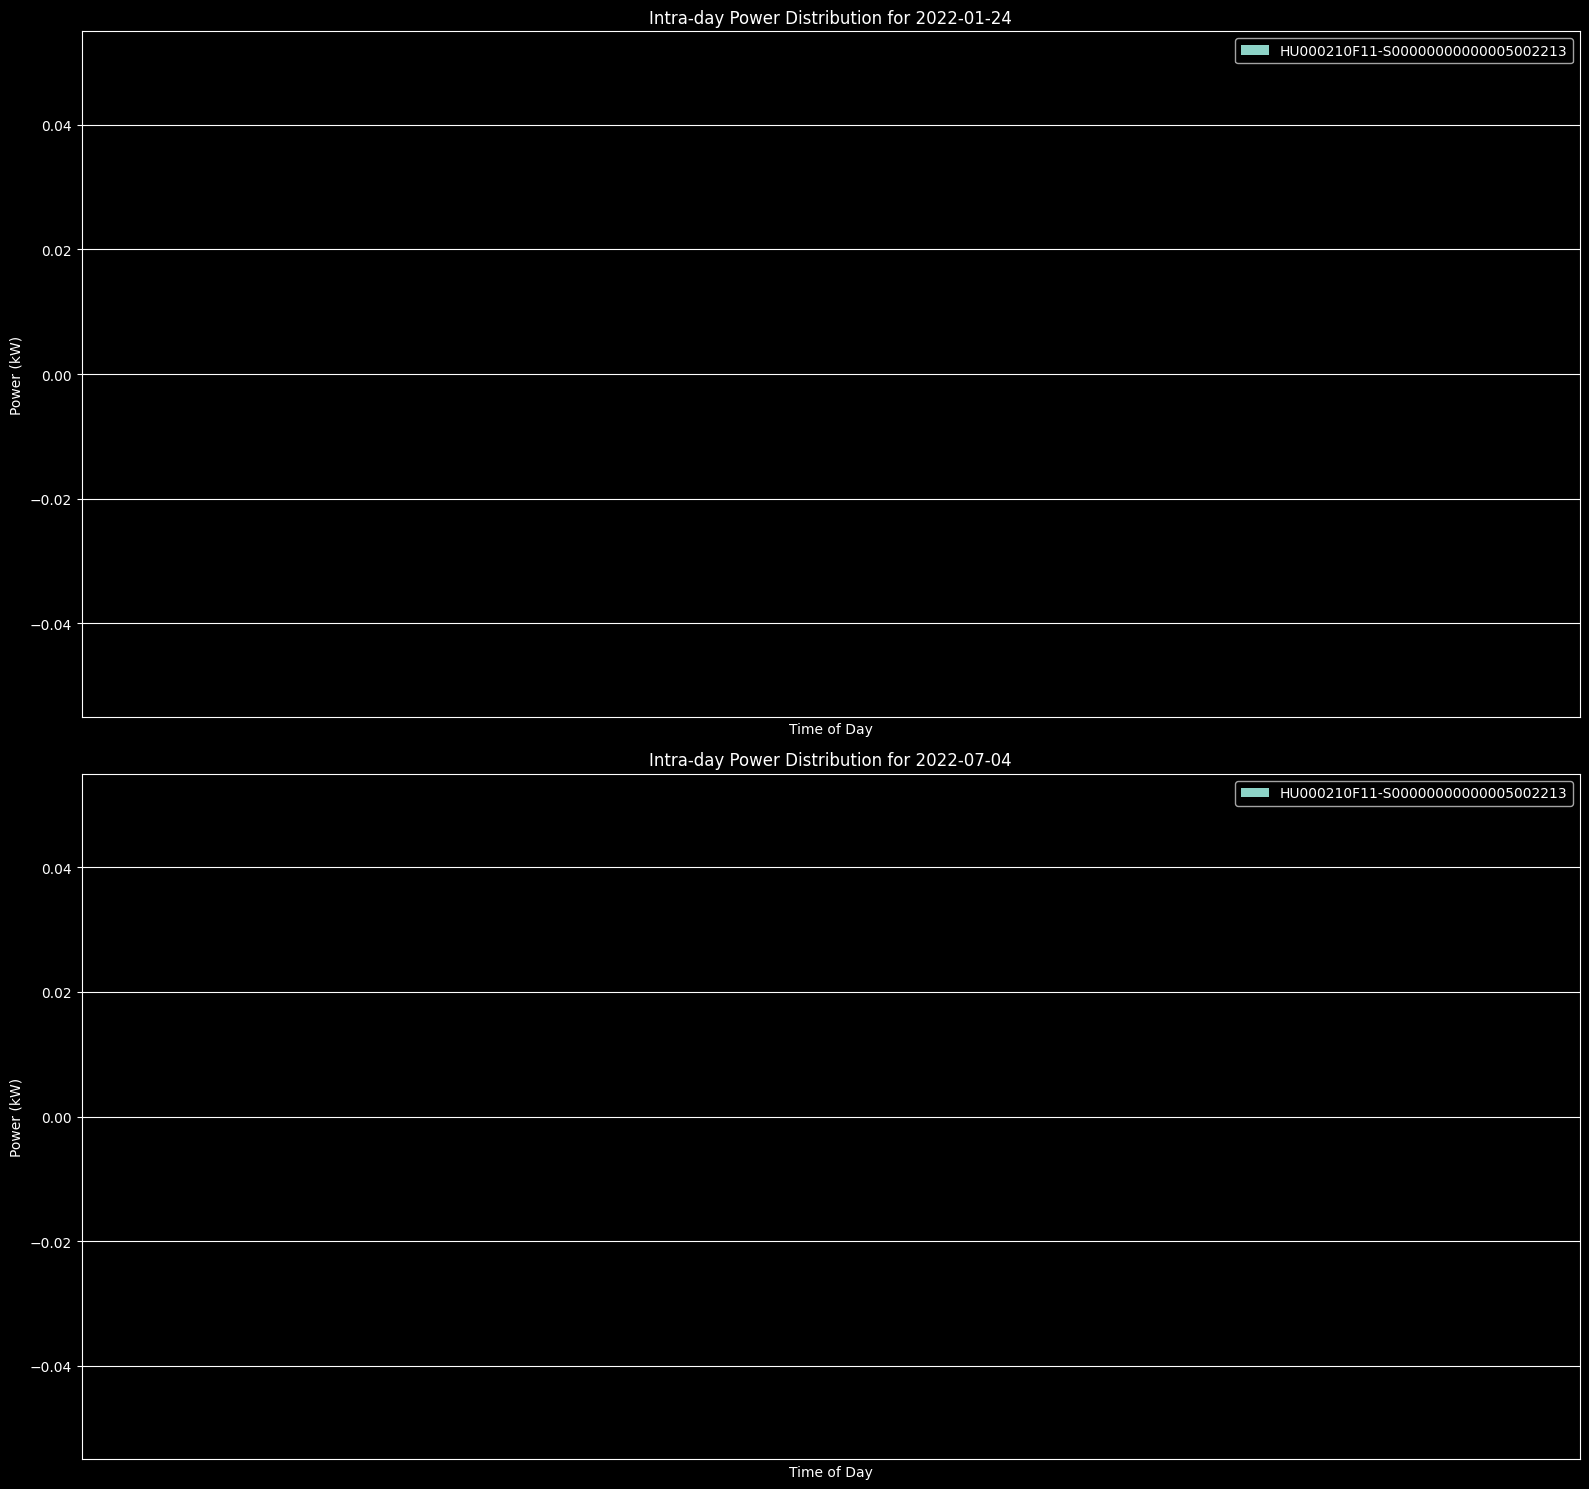

In [14]:
# Dates of interest
dates_of_interest = ['2022-01-24', '2022-07-04']

# Visualization
fig, axes = plt.subplots(nrows=len(dates_of_interest), ncols=1, figsize=(16, 15))  # Adjusted the figure size

for idx, date in enumerate(dates_of_interest):
    ax = axes[idx]
    
    # Subset for the date
    subset = processed_data[processed_data['TimePeriodStart'].dt.date == pd.to_datetime(date).date()]
    
    # Extract data for each consumption column and stack them
    bar_data = [subset[col].values for col in all_consumption_columns]
    cum_data = np.cumsum(bar_data, axis=0)
    
    for i, col in enumerate(all_consumption_columns):
        if i == 0:
            ax.bar(subset['TimePeriodStart'].dt.strftime('%H:%M'), bar_data[i], label=col)
        else:
            ax.bar(subset['TimePeriodStart'].dt.strftime('%H:%M'), bar_data[i], bottom=cum_data[i - 1], label=col)
    
    # Adjusting the subplot
    ax.set_title(f'Intra-day Power Distribution for {date}')
    ax.set_xlabel('Time of Day')
    ax.set_ylabel('Power (kW)')
    time_labels = subset['TimePeriodStart'].dt.strftime('%H:%M')
    ax.set_xticks(np.arange(len(time_labels)))
    ax.set_xticklabels(time_labels, rotation=45)
    ax.legend()
    ax.grid(axis='y')

plt.tight_layout()
plt.show()

### Task 6: Visualizing Quarterly Consumption

This task aims to understand the distribution of daily energy consumption for each meter:

1. Histograms are created for each meter to show the distribution of daily energy consumption values.
2. These histograms provide insights into the frequency of different daily consumption values for each meter, highlighting common consumption patterns and any anomalies.

In [ ]:
# Compute the daily energy consumption for each meter
processed_data['Date'] = processed_data['TimePeriodStart'].dt.date
daily_consumption = processed_data.groupby('Date')[all_consumption_columns].sum()

# Setting up the plotting environment
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))

# Plotting histograms for each meter
for idx, column in enumerate(all_consumption_columns):
    sns.histplot(daily_consumption[column], ax=axes[idx], bins=30, kde=True, color='skyblue', edgecolor='black')
    
    # Setting titles and labels for each subplot
    axes[idx].set_title(f'Distribution of Daily Energy Consumption for {column}')
    axes[idx].set_xlabel('Daily Energy Consumption (kWh)')
    axes[idx].set_ylabel('Frequency')

# Adjusting the layout to prevent overlap
plt.tight_layout()

# Displaying the plots
plt.show()


### Task 8: Anomaly detection
Here's a basic approach to detect anomalies using the interquartile range (IQR):

IQR Method:
- Calculate the first (Q1) and third quartiles (Q3) for the data.
- Compute the IQR: IQR=Q3−Q1IQR=Q3−Q1.
- Define a threshold for outliers, typically 1.5 times the IQR below Q1 and above Q3.
- Data points outside of this range are considered anomalies.

Let's implement this for daily energy consumption:

In [ ]:
# For each meter, calculate Q1, Q3, IQR, and the bounds for outliers
thresholds = {}

for column in all_consumption_columns:
    Q1 = daily_consumption[column].quantile(0.25)
    Q3 = daily_consumption[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - THRESHOLD_FOR_OUTLIERS * IQR
    upper_bound = Q3 + THRESHOLD_FOR_OUTLIERS * IQR
    
    thresholds[column] = {"Lower Bound": lower_bound, "Upper Bound": upper_bound}

# Display thresholds for each meter
for meter, bounds in thresholds.items():
    print(f"Thresholds for {meter}:")
    print(f"  - Lower Bound: {bounds['Lower Bound']:.2f}")
    print(f"  - Upper Bound: {bounds['Upper Bound']:.2f}")
    print("\n")


In [ ]:
# For each meter, calculate Q1, Q3, IQR, and the bounds for outliers
anomaly_dates = {}

for column in all_consumption_columns:
    Q1 = daily_consumption[column].quantile(0.25)
    Q3 = daily_consumption[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - THRESHOLD_FOR_OUTLIERS * IQR
    upper_bound = Q3 + THRESHOLD_FOR_OUTLIERS * IQR
    
    # Extract dates of the anomalies
    anomaly_dates[column] = daily_consumption[(daily_consumption[column] < lower_bound) | (daily_consumption[column] > upper_bound)].index

# Display dates of anomalies for each meter
for meter, dates in anomaly_dates.items():
    print(f"Anomaly Dates for {meter}:")
    for date in dates:
        print(f"  - {date.strftime('%Y-%m-%d')}")
    print("\n")


In [ ]:
# For each meter, calculate Q1, Q3, IQR, and the bounds for outliers
anomalies = {}

for column in all_consumption_columns:
    Q1 = daily_consumption[column].quantile(0.25)
    Q3 = daily_consumption[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - THRESHOLD_FOR_OUTLIERS * IQR
    upper_bound = Q3 + THRESHOLD_FOR_OUTLIERS * IQR
    
    # Filter out the anomalies
    anomalies[column] = daily_consumption[(daily_consumption[column] < lower_bound) | (daily_consumption[column] > upper_bound)]

# Plotting the daily consumption along with anomalies
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))

for idx, column in enumerate(all_consumption_columns):
    axes[idx].plot(daily_consumption.index, daily_consumption[column], label='Daily Consumption', color='blue')
    axes[idx].scatter(anomalies[column].index, anomalies[column][column], color='red', label='Anomalies')
    axes[idx].set_title(f'Daily Energy Consumption with Anomalies for {column}')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Daily Energy Consumption (kWh)')
    axes[idx].legend()

plt.tight_layout()
plt.show()

### Task 8: Solar Panel Production vs Consumption
One of the sustainable solutions to energy needs is harnessing solar power. In this section, we'll compare solar panel production against consumption. This will provide insights into how self-produced energy matches up against consumption and where additional energy sources might be needed.
Understanding the Problem:

Often, solar panels produce more energy than is consumed by a facility or household. This excess energy, if not stored or fed back into the grid, is essentially wasted. By identifying the days and the amount of excess energy produced, facilities can make informed decisions, such as investing in energy storage solutions or adjusting their energy consumption patterns.
Approach:

To visualize and calculate the excess energy produced by the solar panels, we take the following steps:

1. **Filtering Excess Intervals:**
For each 15-minute interval in the dataset, we identify periods where the energy generated by the solar panel exceeds the energy consumed.
    ```python
    excess_intervals = data[data[solar_panel_col] > data[meter_col]]
    ```

2. **Calculating Excess Energy:**
    For each of these intervals, we calculate the difference between the energy generated by the solar panel and the energy consumed. This difference represents the "excess energy" for that interval.
    ```python
    excess_intervals['Excess'] = excess_intervals[solar_panel_col] - excess_intervals[meter_col]
    ```

3. **Aggregating Excess Energy by Day:**
    We then aggregate this "excess energy" for each day to get a daily summary of excess energy production.
    ```python
    daily_excess = excess_intervals.groupby(excess_intervals['TimePeriodStart'].dt.date)['Excess'].sum()
    ```

4. **Visualization:**
    A bar chart provides a visual representation of the excess energy produced each day. This helps in quickly identifying days with higher excess energy production.
    ```python
    daily_excess.plot(kind='bar', color='skyblue')
    ```

In [ ]:
def plot_and_calculate_net(data, meter_col, solar_panel_col):
    # Calculate the net energy for each interval (positive or negative)
    data['Net'] = data[solar_panel_col] - data[meter_col]

    # Aggregate this "net energy" for each day
    daily_data = data.groupby(data['TimePeriodStart'].dt.date).agg({meter_col: 'sum', solar_panel_col: 'sum', 'Net': 'sum'}).reset_index()

    # Aggregate the monthly consumption, production, and net balance
    monthly_data = data.groupby(data['TimePeriodStart'].dt.to_period("M")).agg({meter_col: 'sum', solar_panel_col: 'sum', 'Net': 'sum'}).reset_index()

    # Print out the monthly summaries
    for index, row in monthly_data.iterrows():
        month = row['TimePeriodStart'].strftime('%B %Y')
        print(f"Month: {month}")
        print(f"Monthly Consumption for {meter_col}: {row[meter_col]:.2f} kWh")
        print(f"Monthly Production from {solar_panel_col}: {row[solar_panel_col]:.2f} kWh")
        print(f"Net Balance (Production - Consumption) for {meter_col}: {row['Net']:.2f} kWh")
        print('---')

    # Plot using a stacked area chart for daily data
    plt.figure(figsize=(16, 8))
    plt.stackplot(daily_data['TimePeriodStart'], daily_data[meter_col], daily_data['Net'], labels=['Consumption', 'Net Production (Excess/Deficit)'], colors=['orange', 'skyblue'], alpha=0.7)
    
    plt.title(f'Daily Consumption and Net Solar Production for {meter_col}')
    plt.ylabel('Energy (kWh)')
    plt.xlabel('Date')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Print out total net energy
    total_net_energy = daily_data['Net'].sum()
    print(f"Total Net Energy for {meter_col}: {total_net_energy:.2f} kWh")

# Ensure the solar panel column exists in the data
for meter, solar_panel in pods.items():
    if solar_panel[1] in processed_data.columns:
        plot_and_calculate_net(processed_data, meter, solar_panel[1])


In [ ]:
def plot_and_calculate_excess(data, meter_col, solar_panel_col):
    # Filter intervals with excess production
    excess_intervals = data[data[solar_panel_col] > data[meter_col]]

    # Calculate the excess energy for each interval
    excess_intervals['Excess'] = excess_intervals[solar_panel_col] - excess_intervals[meter_col]

    # Aggregate this "excess energy" for each day
    daily_data = excess_intervals.groupby(excess_intervals['TimePeriodStart'].dt.date).agg({meter_col: 'sum', 'Excess': 'sum'}).reset_index()

    # Plot using a stacked area chart
    plt.figure(figsize=(16, 8))
    plt.stackplot(daily_data['TimePeriodStart'], daily_data[meter_col], daily_data['Excess'], labels=['Consumption', 'Excess Production'], colors=['orange', 'skyblue'], alpha=0.7)
    
    plt.title(f'Daily Consumption and Excess Solar Production for {meter_col}')
    plt.ylabel('Energy (kWh)')
    plt.xlabel('Date')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Print out total excess energy
    total_excess_energy = daily_data['Excess'].sum()
    print(f"Total Excess Energy for {meter_col}: {total_excess_energy:.2f} kWh")

# Ensure the solar panel column exists in the data
for meter, solar_panel in pods.items():
    if solar_panel[1] in processed_data.columns:
        plot_and_calculate_excess(processed_data, meter, solar_panel[1])


In [ ]:
def plot_monthly_stacked_area_chart(data, meter_col, solar_panel_col):
    # Group data by month and sum values
    monthly_data = data.groupby(data['TimePeriodStart'].dt.to_period("M"))[[meter_col, solar_panel_col]].sum().reset_index()
    monthly_data['TimePeriodStart'] = monthly_data['TimePeriodStart'].dt.to_timestamp()

    # Calculate the monthly excess energy
    monthly_data['Excess'] = monthly_data[solar_panel_col] - monthly_data[meter_col]
    monthly_excess = monthly_data[['TimePeriodStart', 'Excess']]

    plt.figure(figsize=(16, 8))
    plt.stackplot(monthly_data['TimePeriodStart'], monthly_data[meter_col], monthly_data[solar_panel_col], labels=['Consumption', 'Production'], alpha=0.6)
    plt.title(f'Monthly Energy Consumption vs Solar Production for {meter_col}')
    plt.ylabel('Energy (kWh)')
    plt.xlabel('Date')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Print out monthly excess or deficit energy
    for _, row in monthly_excess.iterrows():
        if row['Excess'] < 0:
            print(f"Energy Deficit for {row['TimePeriodStart'].strftime('%B %Y')}: {-row['Excess']:.2f} kWh")
        else:
            print(f"Excess Energy for {row['TimePeriodStart'].strftime('%B %Y')}: {row['Excess']:.2f} kWh")


for meter, solar_panel in pods.items():
    if solar_panel[1] in processed_data.columns:  # Ensure the solar panel column exists
        plot_monthly_stacked_area_chart(processed_data, meter, solar_panel[1])


In [ ]:
def plot_monthly_stacked_area_chart(data, meter_col, solar_panel_col):
    # Group data by month and sum values
    monthly_data = data.groupby(data['TimePeriodStart'].dt.to_period("M"))[[meter_col, solar_panel_col]].sum().reset_index()
    monthly_data['TimePeriodStart'] = monthly_data['TimePeriodStart'].dt.to_timestamp()
    
    plt.figure(figsize=(16, 8))
    plt.stackplot(monthly_data['TimePeriodStart'], monthly_data[meter_col], monthly_data[solar_panel_col], labels=['Consumption', 'Production'], alpha=0.6)
    plt.title(f'Monthly Energy Consumption vs Solar Production for {meter_col}')
    plt.ylabel('Energy (kWh)')
    plt.xlabel('Date')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

for meter, solar_panel in pods.items():
    if solar_panel[1] in processed_data.columns:  # Ensure the solar panel column exists
        plot_monthly_stacked_area_chart(processed_data, meter, solar_panel[1])


In [ ]:
def plot_monthly_line_chart_seaborn(data, meter_col, solar_panel_col):
    # Group data by month and sum values
    monthly_data = data.groupby(data['TimePeriodStart'].dt.to_period("M"))[[meter_col, solar_panel_col]].sum().reset_index()
    monthly_data['TimePeriodStart'] = monthly_data['TimePeriodStart'].dt.to_timestamp()
    
    plt.figure(figsize=(16, 8))
    sns.lineplot(data=monthly_data, x='TimePeriodStart', y=meter_col, label='Consumption', marker='o')
    sns.lineplot(data=monthly_data, x='TimePeriodStart', y=solar_panel_col, label='Production', marker='o')
    plt.title(f'Monthly Energy Consumption vs Solar Production for {meter_col}')
    plt.ylabel('Energy (kWh)')
    plt.xlabel('Date')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

for meter, solar_panel in pods.items():
    if solar_panel[1] in processed_data.columns:  # Ensure the solar panel column exists
        plot_monthly_line_chart_seaborn(processed_data, meter, solar_panel[1])


### Task 9: Understanding Car Charger Energy Consumption

The provided code snippet undertakes the adjustment of electric car charging circuit consumption patterns throughout the day. In essence, it operates in four key steps:

***Adjust the Charging Circuit Consumption:*** The raw consumption data undergoes adjustments to adhere to specific thresholds depending on the time of day. For instance, between midnight and 10 AM, the charging circuit's consumption is capped at a maximum of 3kWh for every 15 minutes. Meanwhile, between 10 AM and 3 PM, the ceiling is raised to 25kWh for every 15 minutes.

***Aggregate Total Consumption:*** A new column, named 'TotalConsumption', is created in the dataset. It sums the consumption values across all meters, inclusive of electric car chargers, for every row in the data.

***Smooth Out the Consumption Curve:*** To manage power load between 10 AM and 3 PM, the code computes the average charging circuit consumption during these hours and distributes this value evenly. This results in a smoother, more consistent power load throughout these midday hours. Following this, the 'AdjustedTotalConsumption' is recalculated to reflect these changes.

***Visualization and Calculation:*** The original and adjusted total consumptions are plotted side-by-side to allow a visual comparison. Post-visualization, the script calculates the amount of energy saved due to these adjustments during midday hours.

### Logic Breakdown:

#### 1. Seaborn Style Setting:
- Set the style for the Seaborn plots to "whitegrid". This style provides a white background with a grid to aid in readability.

#### 2. TimePeriodStart Conversion:
- Convert the 'TimePeriodStart' column in `adjusted_data` to a datetime format. This ensures the data can be correctly processed as dates and times.

#### 3. Extracting Date:
- From the 'TimePeriodStart' column, extract only the date (i.e., year-month-day) and store it in a new column called 'Date'.

#### 4. Group by Date and Aggregate:
- Group the data by 'Date'.
- Sum the 'TotalConsumption' and 'AdjustedTotalConsumption' for each date to get daily total consumption values.

#### 5. Calculate Consumption Difference:
- For each date, compute the difference between 'AdjustedTotalConsumption' and 'TotalConsumption'. This difference shows the amount of consumption that was adjusted.

#### 6. Plotting:
- Create a new figure with a size of 16x8 inches.
- Plot the 'TotalConsumption' for each date as a bar plot. This represents the original consumption.
- On top of the original consumption, plot the difference in consumption (the adjustment). This "stacks" on top of the original consumption bars and visually represents the adjustment made.
- Set the x-axis label as 'Date', the y-axis label as 'Total Consumption (kWh)', and provide a title for the plot.
- Rotate the x-axis labels (dates) by 45 degrees for better readability.
- Add a legend to differentiate between original and adjusted consumption.

#### 7. Show the Plot:
- Display the created plot.

#### 8. Calculate Midday Savings:
- Filter the data to only include rows corresponding to midday hours (as defined by the `mask_midday` mask).
- Calculate the total original consumption and total adjusted consumption for these midday hours.

#### 9. Compute Saved kWh:
- Subtract the adjusted consumption from the original consumption to determine the amount of energy saved by the adjustments made during midday hours.

#### 10. Display Savings:
- Print the saved kWh value with a formatted message indicating the total energy saved during midday hours due to the adjustments in the charging circuit consumption.

In essence, this script visualizes the daily consumption of energy, comparing the original consumption to the adjusted consumption. The adjustments made (especially during midday) lead to savings in energy, which are also quantified and presented at the end.


In [ ]:
# Setting the style for seaborn
sns.set_style("whitegrid")

# Convert 'TimePeriodStart' to datetime (in case it isn't already)
adjusted_data['TimePeriodStart'] = pd.to_datetime(adjusted_data['TimePeriodStart'])

# Extract date for grouping later
adjusted_data['Date'] = adjusted_data['TimePeriodStart'].dt.date

# Group by Date and sum TotalConsumption and AdjustedTotalConsumption
daily_summary = adjusted_data.groupby('Date').agg({'TotalConsumption': 'sum', 'AdjustedTotalConsumption': 'sum'}).reset_index()

# Calculate the difference to stack the bars
daily_summary['ConsumptionDiff'] = daily_summary['AdjustedTotalConsumption'] - daily_summary['TotalConsumption']

## Plotting
plt.figure(figsize=(16, 8))

# Plotting the base (Original Total Consumption)
sns.barplot(data=daily_summary, x='Date', y='TotalConsumption', color='skyblue', label='Original Total Consumption')

# Plotting the difference (Adjusted - Original)
sns.barplot(data=daily_summary, x='Date', y='ConsumptionDiff', bottom=daily_summary['TotalConsumption'], color='salmon', label='Adjusted Total Consumption')

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Total Consumption (kWh)')
plt.title('Comparison of Original and Adjusted Total Consumption')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# Calculate total original and adjusted consumption for midday hours
total_original_consumption_midday = adjusted_data.loc[mask_midday, 'TotalConsumption'].sum()
total_adjusted_consumption_midday = adjusted_data.loc[mask_midday, 'AdjustedTotalConsumption'].sum()

# Calculate saved kWh again
saved_kwh = total_original_consumption_midday - total_adjusted_consumption_midday

# Format the saved kWh value
print(f"We saved a total of {saved_kwh:.2f} kWh during the midday hours by adjusting the charging circuit consumption.")


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Setting the style for seaborn
sns.set_style("whitegrid")

# Convert 'TimePeriodStart' to datetime (in case it isn't already)
adjusted_data['TimePeriodStart'] = pd.to_datetime(adjusted_data['TimePeriodStart'])

# Extract month for grouping later
adjusted_data['Month'] = adjusted_data['TimePeriodStart'].dt.month_name()

# Group by Month and sum TotalConsumption and AdjustedTotalConsumption
monthly_summary = adjusted_data.groupby('Month').agg({'TotalConsumption': 'sum', 'AdjustedTotalConsumption': 'sum'}).reset_index()

# Calculate the difference to stack the bars
monthly_summary['ConsumptionDiff'] = monthly_summary['AdjustedTotalConsumption'] - monthly_summary['TotalConsumption']

## Plotting
plt.figure(figsize=(16, 8))

# Plotting the base (Original Total Consumption)
sns.barplot(data=monthly_summary, x='Month', y='TotalConsumption', color='skyblue', label='Original Total Consumption')

# Plotting the difference (Adjusted - Original)
sns.barplot(data=monthly_summary, x='Month', y='ConsumptionDiff', bottom=monthly_summary['TotalConsumption'], color='salmon', label='Adjusted Total Consumption')

# Formatting the plot
plt.xlabel('Month')
plt.ylabel('Total Consumption (kWh)')
plt.title('Comparison of Original and Adjusted Total Consumption by Month')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# Calculate total original and adjusted consumption for midday hours
total_original_consumption_midday = adjusted_data.loc[mask_midday, 'TotalConsumption'].sum()
total_adjusted_consumption_midday = adjusted_data.loc[mask_midday, 'AdjustedTotalConsumption'].sum()

# Calculate saved kWh again
saved_kwh = total_original_consumption_midday - total_adjusted_consumption_midday

# Format the saved kWh value
print(f"We saved a total of {saved_kwh:.2f} kWh during the midday hours by adjusting the charging circuit consumption.")


In [ ]:
# Compute the intra-day average consumption for both original and adjusted data
avg_original = adjusted_data.groupby(['Hour', 'Minute'])['TotalConsumption'].mean().reset_index()
avg_adjusted = adjusted_data.groupby(['Hour', 'Minute'])['AdjustedTotalConsumption'].mean().reset_index()

# Merge the two average consumptions into a single dataframe for comparison
intra_day_comparison = pd.merge(avg_original, avg_adjusted, on=['Hour', 'Minute'], how='inner')
intra_day_comparison['Time'] = intra_day_comparison['Hour'].astype(str).str.zfill(2) + ':' + intra_day_comparison['Minute'].astype(str).str.zfill(2)
intra_day_comparison.rename(columns={"TotalConsumption": "Original Average Consumption", "AdjustedTotalConsumption": "Adjusted Average Consumption"}, inplace=True)

# Now, let's plot the shaded difference between the two curves
plt.figure(figsize=(16, 8))

sns.lineplot(x='Time', y='Original Average Consumption', data=intra_day_comparison, label='Original Average Consumption', linewidth=2)
sns.lineplot(x='Time', y='Adjusted Average Consumption', data=intra_day_comparison, label='Adjusted Average Consumption', linewidth=2)

plt.fill_between(intra_day_comparison['Time'], 
                 intra_day_comparison['Original Average Consumption'], 
                 intra_day_comparison['Adjusted Average Consumption'], 
                 where=(intra_day_comparison['Adjusted Average Consumption'] < intra_day_comparison['Original Average Consumption']),
                 color='red', alpha=0.4, label='Reduced Consumption')
plt.fill_between(intra_day_comparison['Time'], 
                 intra_day_comparison['Original Average Consumption'], 
                 intra_day_comparison['Adjusted Average Consumption'], 
                 where=(intra_day_comparison['Adjusted Average Consumption'] > intra_day_comparison['Original Average Consumption']),
                 color='green', alpha=0.4, label='Increased Consumption')

plt.xlabel('Time of Day')
plt.ylabel('Average Consumption (kWh)')
plt.title('Intra-day Comparison of Original and Adjusted Average Consumption')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

### Task 10: Final Observations and Conclusions

After analyzing various facets of the energy consumption data, it's essential to consolidate our findings, draw conclusions, and provide actionable insights. In this section, we'll summarize the key observations and suggest further steps or considerations.

#TODO: Add final thoughts